# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


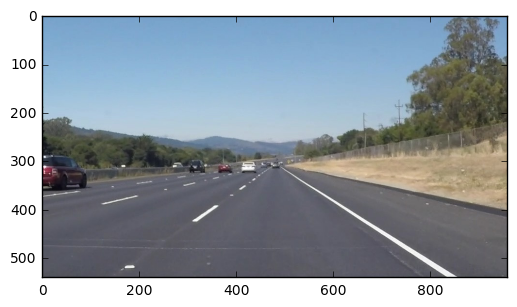

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    image_COLOR_BGR2HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV);
    return image_COLOR_BGR2HSV[:,:,2]
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

<ipython-input-5-5056067f15af>:94: SyntaxWarning: name 'last_cluster_centers' is assigned to before global declaration
  global last_cluster_centers


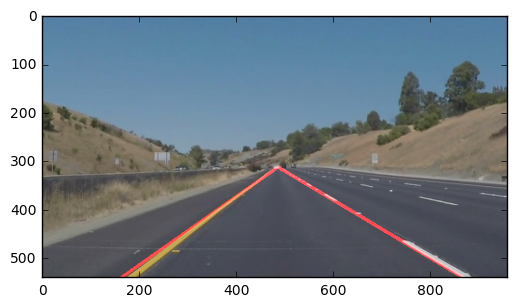

In [5]:
from sklearn.cluster import KMeans

def process (input):
    calibration = {
     # The Mask settings are dependant on camera/environment attributes
     "mask": {
            'lower_left':(0.2, 0.9),   # percent of frame used for masking
            'upper_left':(0.55, 0.5),
            'upper_right':(0.55, 0.5),
            'lower_right':(0.8, 0.9)
        },
     # Bilateral fitlering settings
     "blur": {
            'd':9,            # Diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace
            'sigmaColor':100, # Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace ) will be mixed together, resulting in larger areas of semi-equal color.
            'sigmaSpace':100  # Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor ). When d>0 , it specifies the neighborhood size regardless of sigmaSpace . Otherwise, d is proportional to sigmaSpace .
        },
     # Canny edge detection parameters
     "canny": {
            'threshold1':25, # first threshold for the hysteresis procedure.
            'threshold2':200 # second threshold for the hysteresis procedure.
        },
     # Hough transform parameters
     "hough": {
            'rho':1,                     # Distance resolution of the accumulator in pixels.
            'theta':math.radians(0.25),  # Angle resolution of the accumulator in radians.
            'threshold':45,              # Accumulator threshold parameter. Only those lines are returned that get enough votes ( >threshold )
            'min_line_length':25,        # Minimum line length. Line segments shorter than that are rejected.
            'max_line_gap':100           # Maximum allowed gap between points on the same line to link them.
        },
     # Lane angles for filtering
     "lanes": {
            'left_min':math.radians(110), # Left most angle of left lane
            'left_max':math.radians(130), # Right most angle of left lane
            'right_min':math.radians(50), # Right most angle of right lane
            'right_max':math.radians(70)  # Left most angle of right lane.
        }
    }

    # Convert to grayscale
    grayscale_image = grayscale(input)
    
    # Auto level image
    equalized_image = cv2.equalizeHist(grayscale_image)
    #plt.imshow(equalized_image, cmap='gray')
    
    # Blur
    blurred_image = cv2.bilateralFilter(equalized_image,calibration["blur"]["d"],calibration["blur"]["sigmaColor"],calibration["blur"]["sigmaSpace"])
#    plt.imshow(blurred_image, cmap='gray')
    
    # Canny edge detection
    canny_image = cv2.Canny(blurred_image, calibration["canny"]["threshold1"], calibration["canny"]["threshold2"])
    
    # Mask image
    quadrilateral = np.array([[(image.shape[1]*calibration["mask"]["lower_left"][0], image.shape[0]*calibration["mask"]["lower_left"][1]),
                               (image.shape[1]*calibration["mask"]["upper_left"][0], image.shape[0]*calibration["mask"]["upper_left"][1]),
                               (image.shape[1]*calibration["mask"]["upper_right"][0], image.shape[0]*calibration["mask"]["upper_right"][1]),
                               (image.shape[1]*calibration["mask"]["lower_right"][0], image.shape[0]*calibration["mask"]["lower_right"][1])]],
                             dtype=np.int32)
    masked_image = region_of_interest(canny_image, quadrilateral)
#    plt.imshow(masked_image, cmap='gray')
    
    # Standard Hough Transform - we want rho,theta output
    lines = cv2.HoughLines(masked_image,
                           calibration["hough"]["rho"],
                           calibration["hough"]["theta"],
                           calibration["hough"]["threshold"]
                           )
    line_list = lines.reshape(-1,2)
    filtered_line_list = [rhotheta for rhotheta in line_list if ((rhotheta[1] > calibration["lanes"]["right_min"] and 
                                                                  rhotheta[1] < calibration["lanes"]["right_max"]) or
                                                                 (rhotheta[1] > calibration["lanes"]["left_min"] and
                                                                  rhotheta[1] < calibration["lanes"]["left_max"]))]
    
    # Check if list is empty - you could start making failsafes for edge cases
    if not filtered_line_list:
        print("list not empty")
        
    # Use KMeans cluster prediction for two main clusters (hopefully left and right line) and use their centroids
    cluster = KMeans(n_clusters=2)
    cluster.fit_predict(filtered_line_list)
    
    # Smooth out cluster centers based on detection history
    if 'last_cluster_centers' in globals():
        # Cluster previous cluster with current cluster
        last_cluster_centers = np.concatenate((last_cluster_centers[2:4],
                                               last_cluster_centers[4:6],
                                               last_cluster_centers[6:8],
                                               last_cluster_centers[8:10],
                                               cluster.cluster_centers_), axis=0)
        # Fit predict centroids again, this time with previous centroids forming the cluster
        cluster.fit_predict(last_cluster_centers)
    else:
        global last_cluster_centers
        last_cluster_centers = np.concatenate((cluster.cluster_centers_,
                                               cluster.cluster_centers_,
                                               cluster.cluster_centers_,
                                               cluster.cluster_centers_,
                                               cluster.cluster_centers_), axis=0) 
    
    # Determine the intersection in x,y for rho,theta lines
    ct1 = np.cos(cluster.cluster_centers_[0,1])     # matrix element a
    st1 = np.sin(cluster.cluster_centers_[0,1])     # b
    ct2 = np.cos(cluster.cluster_centers_[1,1])     # c
    st2 = np.sin(cluster.cluster_centers_[1,1])     # d
    d = ct1 * st2 - st1 * ct2                       # determinative (rearranged matrix for inverse)
    if (d != 0):
            intersect_x = (st2 * cluster.cluster_centers_[0,0] - st1 * cluster.cluster_centers_[1,0]) / d
            intersect_y = (-ct2 * cluster.cluster_centers_[0,0] + ct1 * cluster.cluster_centers_[1,0]) / d
            intersect = 1
    else:  # lines are parallel, this probably won't happen since we aggressively filter the hough output
            intersect = 0
    
    # The line length should at least be the size of the image, drawing outside of the image is ok.
    line_length = image.shape[0]
    
    # Prepare a blank image
    clustered_line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # Draw lane lines based on the centroids of the cluster detection
    for rho,theta in cluster.cluster_centers_:
        a = np.cos(theta)
        b = np.sin(theta)
#        x0 = a*rho
#        y0 = b*rho
        # instead of drawing lines through the entire image, start at the previously determined intersection
        x0 = intersect_x
        y0 = intersect_y
        if (a < 0):
            x1 = int(x0)
            y1 = int(y0)
            x2 = int(x0 - line_length*(-b))
            y2 = int(y0 - line_length*(a))
        else:
            x1 = int(x0 + line_length*(-b))
            y1 = int(y0 + line_length*(a))
            x2 = int(x0)
            y2 = int(y0)
#        print(x1, y1)
#        print(x2, y2)
        cv2.line(clustered_line_image,(x1,y1),(x2,y2),(255,0,0),5)
    
#    plt.imshow(clustered_line_image)
    # draw lanes on original image
    return weighted_img(clustered_line_image, input)

if 'last_cluster_centers' in globals():
    del last_cluster_centers
input_image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
output_image = process(input_image)
plt.figure()
#plt.imshow(output_image, cmap='gray')
plt.imshow(output_image)

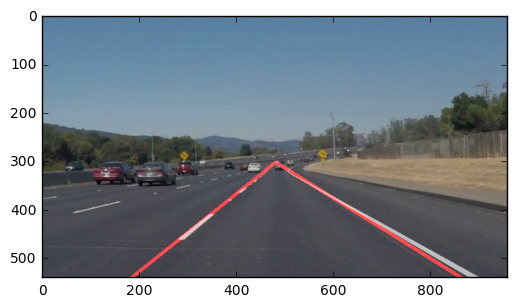

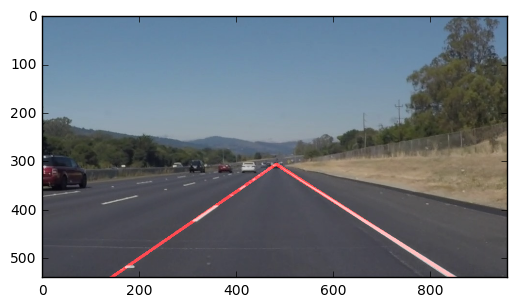

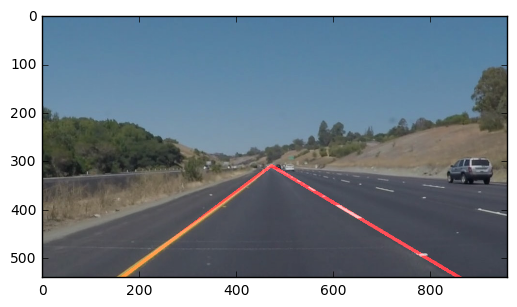

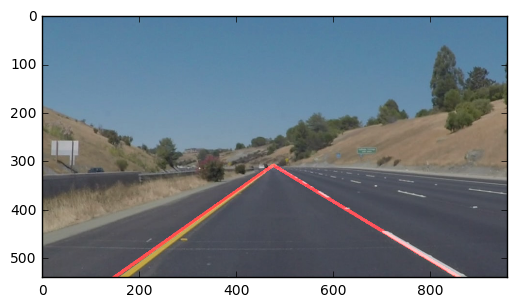

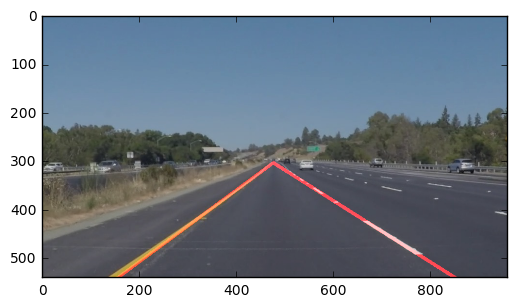

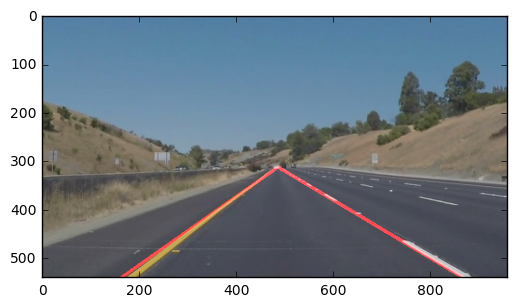

In [6]:
# Iterate over test images
for image_name in os.listdir("test_images/"):
    if 'last_cluster_centers' in globals():
        del last_cluster_centers
    input_image = mpimg.imread('test_images/'+image_name)
    output_image = process(input_image)
    plt.figure()
    plt.imshow(output_image)
    mpimg.imsave('output/'+image_name, output_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [8]:
if 'last_cluster_centers' in globals():
    del last_cluster_centers
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(lambda i: process(i)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:17<00:00, 12.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 18.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
if 'last_cluster_centers' in globals():
    del last_cluster_centers
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lambda i: process(i))
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:55<00:00, 11.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 56 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections
General

- I chose KMeans clustering in the rho/theta space to find the centroids of the output of the Hough transform.  This produced good results and I didn't have to care what lane was left or right.  Filtering the Hough output based on theta and also using multi-frame averaging produced visually pleasing results.

How could you imagine making your algorithm better / more robust?
 
- The algorithm could benefit from curve fitting Hough transforms, adaptive outlier filtering, multi lane tracking (if the car wanders between lanes), covering more edge cases (missing frames and other missing/miscalculated data)

Where will your current algorithm be likely to fail?

- Any environment that isnt a highway and daylight.  (i.e. city / contruction zone / snow / rain / leaves on road / etc).



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
if 'last_cluster_centers' in globals():
    del last_cluster_centers
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(lambda i: process(i))
%time challenge_clip.write_videofile(challenge_output, audio=False)

error: ..\..\..\modules\core\src\arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function cv::arithm_op


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))